In [20]:
#scikit-learn and nltk together to perform NLP and 
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kianh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
#load the data
from sklearn.model_selection import train_test_split
df_tweets = pd.read_csv(r"C:\Users\kianh\finsights\finsights\archive\stock_tweets.csv")
df_yf = pd.read_csv(r"C:\Users\kianh\finsights\finsights\archive\stock_yfinance_data.csv")
#test_size is the proportion of the data to use for testing
#random_state is sets a seed for the random number generator to ensure reproducibility
#split the data into training and testing data
#the following line splits the 'Tweet'
X_train, X_test, y_train, y_test = train_test_split(df_tweets['Tweet'], df_tweets['Tweet'], test_size=0.2, random_state=42)

In [22]:
columns = df_tweets.columns
print(columns)

Index(['Date', 'Tweet', 'Stock Name', 'Company Name'], dtype='object')


In [23]:
#tokenize the data
from nltk.tokenize import word_tokenize
df_tweets['tokens'] = df_tweets['Tweet'].apply(word_tokenize)

In [24]:
#remove the stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df_tweets['text_without_stopwords'] = df_tweets['Tweet'].apply(lambda x: [' '.join([word for word in sentence.split() if word not in stop_words]) for sentence in x])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kianh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
#vectorization - the process of converting data into numerical arrays
#or vectors that can be used as input for a model
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df_tweets['Tweet'])

In [26]:
#modeling
from sklearn.linear_model import LogisticRegression

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of the TfidfVectorizer
#reflects how important a word is o a document in a collection
tfidf = TfidfVectorizer()

# Fit and transform the data to create the term-document matrix
tdm = tfidf.fit_transform(df_tweets['Tweet'])

In [28]:
#Create a term-document matrix
from sklearn.decomposition import TruncatedSVD
import scipy.sparse
#create the sparse matrix after the TfidVectorizer is applied
sparse_matrix = scipy.sparse.csr_matrix(tdm)

#initiliaze TruncatedSVD instance
lsa = TruncatedSVD(n_components=50)

#perform LSA
lsa.fit(sparse_matrix)
#dtm_lsa is a transformed version of the sparse matrix
#the transform method makes lsa(svd) fits lsa model to the model
dtm_lsa = lsa.transform(sparse_matrix)

In [29]:
#inspect the results
print(lsa.singular_values_)

[42.60978993 21.43464641 19.13859676 18.84822208 17.20835508 16.53407935
 15.99605517 15.0209757  14.71313796 14.52760069 14.2273742  13.85727088
 13.56122942 13.44900952 13.37335585 13.21898061 12.96884643 12.95443706
 12.77749657 12.52165786 12.4768943  12.28516181 12.17850703 12.04374105
 12.02477873 11.88498561 11.74475768 11.59473347 11.54298093 11.29523613
 11.27768179 11.15661882 11.10778283 11.06094354 10.93889326 10.85939295
 10.77496899 10.72842506 10.66659035 10.64478096 10.44091818 10.40488134
 10.38618886 10.33163942 10.23668246 10.16554767 10.05989335  9.96412017
  9.94491375  9.83307103]


In [30]:
!pip install annoy

In [31]:
from scipy.sparse import lil_matrix
import annoy

# Initialize a sparse matrix to store the similarity matrix
similarity_matrix = lil_matrix((dtm_lsa.shape[0], dtm_lsa.shape[0]))

# Initialize Annoy index
index = annoy.AnnoyIndex(dtm_lsa.shape[1], 'angular')

# Add items to index
for i in range(dtm_lsa.shape[0]):
    index.add_item(i, dtm_lsa[i])

# Build the index
index.build(10)

# Set k to a relatively small value
k = 10

# Compute the pairwise similarities
for i in range(dtm_lsa.shape[0]):
    nn = index.get_nns_by_item(i, k, include_distances=True)
    for j in range(len(nn[0])):
        similarity_matrix[i,nn[0][j]] = nn[1][j]


# Save the sparse matrix to disk
from scipy.sparse import save_npz
save_npz('similarity_matrix.npz', similarity_matrix.tocsr())

In [32]:
print(dtm_lsa.shape[0])

80793


In [33]:
# Compute the pairwise similarities
# using a subset for now to test my model and keep making progress
dtm_lsa_subset = dtm_lsa[:1000, :]
for i in range(dtm_lsa_subset.shape[0]):
    nn = index.get_nns_by_item(i, dtm_lsa_subset.shape[0], include_distances=True)
    for j in range(len(nn[0])):#replace 1 with len(nn[0])
        similarity_matrix[i,nn[0][j]] = nn[1][j]

In [34]:
#test the LSA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [35]:
#K-means clustering is a way of unsupervised learning
#the K-means clustering algorithm aims to partition a set of points
#where each of the points belongs to the cluster with the nearest mean
#Steps of the K-means algorithm:
#1.Initalize the centroids of the K clusters by choosing K data points randomly from the dataset
#2.Assign each data point to the cluster whose centroid is closet to it.
#3.Recompute the centroid of each cluster as the mean of the points assigned to it.
#4.Repeat 2 and 3 until the assignments of the points to clusters doesnt change

In [36]:
#Ways I can test my model:
# 1.Split data into training/test set
# 2.Cross-validation
# 3.Qualitative evaluation
# 4.Evaluation using external knowledge
# 5.Evaluation using downstream tasks

In [37]:
#initialize the K-mean clustering algorithm
kmeans = KMeans(n_clusters=100)
#fit the LSM to the K-Means algorithm

C:\Users\kianh\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\kianh\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


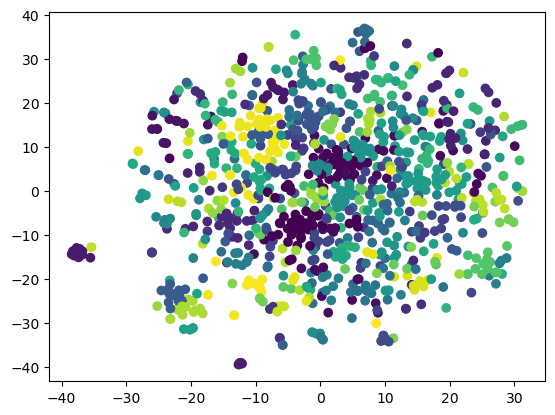

In [38]:
#test the graphical data
#plot the results
#Use t-SNE to reduce the dimensionality of the LSM
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_data = tsne.fit_transform(dtm_lsa_subset)

#Plot the results
kmeans.fit(dtm_lsa_subset)
labels = kmeans.labels_
plt.scatter(low_data[:, 0], low_data[:, 1], c=kmeans.labels_) #used to be "c=kmeans.labels_"
plt.show()


In [46]:
#test the numerical data
from sklearn.metrics import adjusted_rand_score, mean_squared_error

# predict the labels
predicted_labels = kmeans.predict(dtm_lsa_subset)

# calculate the metrics
score = adjusted_rand_score(labels, predicted_labels)
mse = mean_squared_error(labels, predicted_labels)
# print the score
print("Adjusted Rand Score: ", score)
print("Mean Squared Error: ", mse)

Adjusted Rand Score:  1.0
Mean Squared Error:  0.0
